In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.interpretable_functions as interpret
import utils.RiskSLIM as slim
import utils.stumps as stumps
import utils.fairness_functions as fairness
import utils.risktool as risktool
from utils.load_settings import load_settings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

from pprint import pprint
from riskslim.helper_functions import load_data_from_csv, print_model

# restore saved variables
%store -r summary_general2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\interpretable-machine-learning


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_data.csv").sort_values('person_id')
x = data.loc[:,:'current_violence20']
y = data['general_two_year'].values

In [ ]:
#### CART
depth = [5,6,7,8,9,10]
cart_summary = interpret.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [40]
depth = [2]
learning_rate = [0.7]
ebm_summary = interpret.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.7351931906186847, 0.006895104103861738)

In [5]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.740881331803474, 0.002919491491652093)

### Lasso Stumps

 - Notice that controling for the overfitting problem, the more stump features we include, the better prediction results we have. However, we do not want too many features in the model which will violate the definition of interpretability. We control the number of stump features around 30 and the number of original features where the stump features come from to be around 10-12.

In [70]:
## load stumps & original data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_stumps.csv").sort_values('person_id')
original_data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_data.csv").sort_values('person_id')
original_data = original_data.loc[:, ['person_id', 'age_at_current_charge', 'p_charges']]
data = pd.merge(original_data, data, on='person_id')

## split X & Y
X_stumps = data.loc[:,:'current_violence201'].copy()
Y_stumps = data['general_two_year'].values.copy()
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[5:]

## load train & test stumps data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train_stumps.csv").sort_values('person_id')
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_test_stumps.csv").sort_values('person_id')
X_train_stumps = train_stumps.loc[:,:'current_violence201'].copy()
X_test_stumps = test_stumps.loc[:,:'current_violence201'].copy()
Y_train_stumps = train_stumps['general_two_year'].values.copy()
Y_test_stumps = test_stumps['general_two_year'].values.copy()
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Single Stump Model

In [47]:
single_stump_model = stumps.stump_model(X_train_stumps, 
                                        Y_train_stumps, 
                                        X_test_stumps, 
                                        Y_test_stumps, 
                                        c=0.004, 
                                        columns=cols, 
                                        seed=816)
len(single_stump_model['features'])

27

In [9]:
single_stump_model['features']

['age_at_current_charge19',
 'age_at_current_charge20',
 'age_at_current_charge21',
 'age_at_current_charge24',
 'age_at_current_charge27',
 'age_at_current_charge30',
 'age_at_current_charge35',
 'age_at_current_charge39',
 'age_at_current_charge47',
 'p_arrest2',
 'p_arrest3',
 'p_arrest4',
 'p_arrest5',
 'p_arrest6',
 'p_arrest7',
 'p_violence1',
 'p_felony1',
 'p_misdemeanor1',
 'p_drug1',
 'p_drug2',
 'ADE1',
 'p_pending_charge1',
 'p_pending_charge2',
 'p_probation1',
 'p_incarceration1',
 'six_month1',
 'five_year1']

#### Nested Cross Validation

In [10]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.001, 0.002, 0.003, 0.004]}, 
                                seed = 816)

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



In [11]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.004}, {'C': 0.004}, {'C': 0.004}, {'C': 0.004}, {'C': 0.004}],
 0.7391234066079342,
 0.0003223302866098843)

##### Stumps Visualizations

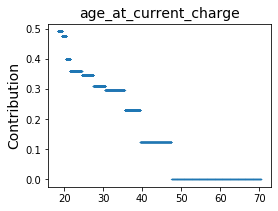

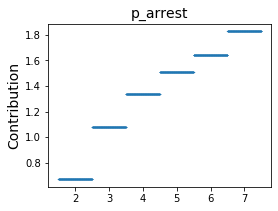

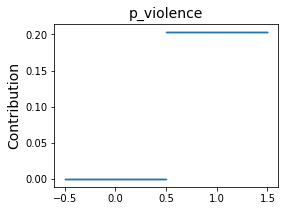

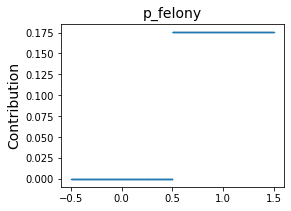

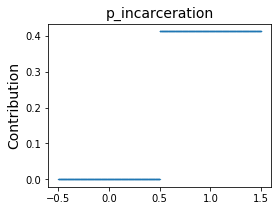

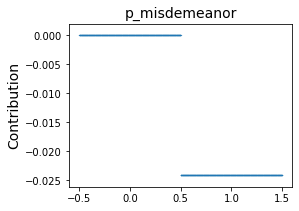

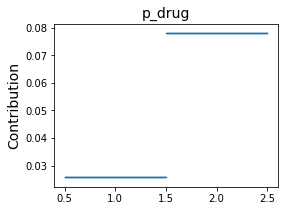

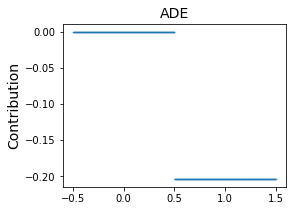

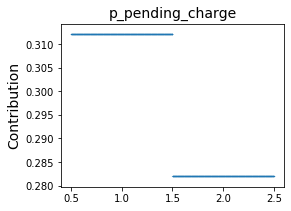

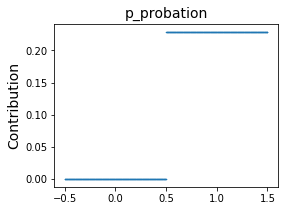

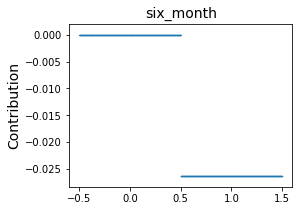

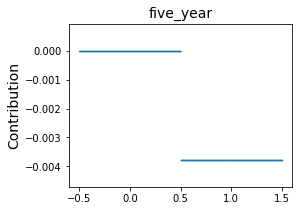

In [13]:
stumps.stump_plots(single_stump_model['features'], single_stump_model['coefs'], indicator="KY")

### RiskSLIM

In [68]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_stumps.csv").sort_values('person_id')

## single stump model
single_stump_model = stumps.stump_model(X_train_stumps, 
                                        Y_train_stumps, 
                                        X_test_stumps, 
                                        Y_test_stumps, 
                                        c=0.0015,    
                                        columns=cols, 
                                        seed=816)
len(single_stump_model['features'])

16

In [71]:
### Subset features
selected_features = single_stump_model['features']
if 'sex1' in selected_features:
    selected_features = ['general_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['general_two_year', 'person_id', 'screening_date', 'race', 'sex1'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_data = pd.merge(sub_data, original_data, on='person_id')
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [72]:
riskslim_summary = slim.risk_nested_cv(X=sub_X, 
                                       Y=sub_Y, 
                                       indicator = indicator,
                                       y_label='general_two_year', 
                                       max_coef=5, 
                                       max_coef_number=5, 
                                       max_runtime=1000, 
                                       max_offset=100,
                                       c=1e-6, 
                                       seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:13 PM | 213 rows in lookup table
12/19/19 @ 03:13 PM | ------------------------------------------------------------
12/19/19 @ 03:13 PM | runnning initialization procedure
12/19/19 @ 03:13 PM | ------------------------------------------------------------
12/19/19 @ 03:13 PM | CPA produced 2 cuts
12/19/19 @ 03:13 PM | running naive rounding on 3 solutions
12/19/19 @ 03:13 PM | best objective value: 0.6931
12/19/19 @ 03:13 PM | rounding produced 3 integer solutions
12/19/19 @ 03:13 PM | best objective value is 0.6931
12/19/19 @ 03:13 PM | running sequential rounding on 3 solutions
12/19/19 @ 03:13 PM | best objective value: 0.6931
12/19/19 @ 03:13 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:13 PM | polishing 3 solutions
12/19/19 @ 03:13 PM | best objective value: 0.6931
12/19/19 @ 03:13 PM | polishing produced 3 integer solutions
12/19/19 @ 03:13 PM | initialization produced 5 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:13 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5582.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:13 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5577.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:14 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5572.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:15 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5573.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:16 PM | rounding produced 4 integer solutions
12/19/19 @ 03:16 PM | best objective value is 0.6931
12/19/19 @ 03:16 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:16 PM | best objective value: 0.6931
12/19/19 @ 03:16 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:16 PM | polishing 4 solutions
12/19/19 @ 03:16 PM | best objective value: 0.6931
12/19/19 @ 03:16 PM | polishing produced 4 integer solutions
12/19/19 @ 03:16 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:16 PM | best objective value: 0.5578
12/19/19 @ 03:16 PM | ------------------------------------------------------------
12/19/19 @ 03:16 PM | completed initialization procedure
12/19/19 @ 03:16 PM | ------------------------------------------------------------
12/19/19 @ 03:16 PM | switching loss computation from lookup to weighted
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel           

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:16 PM | adding 255 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:17 PM | best objective value is 0.6931
12/19/19 @ 03:17 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:17 PM | best objective value: 0.6931
12/19/19 @ 03:17 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:17 PM | polishing 4 solutions
12/19/19 @ 03:17 PM | best objective value: 0.6931
12/19/19 @ 03:17 PM | polishing produced 4 integer solutions
12/19/19 @ 03:17 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:17 PM | best objective value: 0.5577
12/19/19 @ 03:17 PM | ------------------------------------------------------------
12/19/19 @ 03:17 PM | completed initialization procedure
12/19/19 @ 03:17 PM | ------------------------------------------------------------
12/19/19 @ 03:17 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_Tim

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:17 PM | adding 253 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5577.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:18 PM | 213 rows in lookup table
12/19/19 @ 03:18 PM | ------------------------------------------------------------
12/19/19 @ 03:18 PM | runnning initialization procedure
12/19/19 @ 03:18 PM | ------------------------------------------------------------
12/19/19 @ 03:18 PM | CPA produced 2 cuts
12/19/19 @ 03:18 PM | running naive rounding on 4 solutions
12/19/19 @ 03:18 PM | best objective value: 0.6931
12/19/19 @ 03:18 PM | rounding produced 4 integer solutions
12/19/19 @ 03:18 PM | best objective value is 0.6931
12/19/19 @ 03:18 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:18 PM | best objective value: 0.6931
12/19/19 @ 03:18 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:18 PM | polishing 4 solutions
12/19/19 @ 03:18 PM | best objective value: 0.6931
12/19/19 @ 03:18 PM | polishing produced 4 integer solutions
12/19/19 @ 03:18 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:18 PM | adding 252 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5571.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:19 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:19 PM | best objective value: 0.5578
12/19/19 @ 03:19 PM | ------------------------------------------------------------
12/19/19 @ 03:19 PM | completed initialization procedure
12/19/19 @ 03:19 PM | ------------------------------------------------------------
12/19/19 @ 03:19 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52682333068928433
CPXPARAM_MIP_Tolerances_UpperCutoff              0.55783347661472138


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:19 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:20 PM | completed initialization procedure
12/19/19 @ 03:20 PM | ------------------------------------------------------------
12/19/19 @ 03:20 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52662465192563201
CPXPARAM_MIP_Tolerances_UpperCutoff              0.5576134337499673


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:20 PM | adding 255 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5576.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:21 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5558.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:22 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:22 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52656807972569464
CPXPARAM_MIP_Tolerances_UpperCutoff              0.55715833510931756


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:22 PM | adding 256 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5572.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:24 PM | 213 rows in lookup table
12/19/19 @ 03:24 PM | ------------------------------------------------------------
12/19/19 @ 03:24 PM | runnning initialization procedure
12/19/19 @ 03:24 PM | ------------------------------------------------------------
12/19/19 @ 03:24 PM | CPA produced 2 cuts
12/19/19 @ 03:24 PM | running naive rounding on 4 solutions
12/19/19 @ 03:24 PM | best objective value: 0.6931
12/19/19 @ 03:24 PM | rounding produced 4 integer solutions
12/19/19 @ 03:24 PM | best objective value is 0.6931
12/19/19 @ 03:24 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:24 PM | best objective value: 0.6931
12/19/19 @ 03:24 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:24 PM | polishing 4 solutions
12/19/19 @ 03:24 PM | best objective value: 0.6931
12/19/19 @ 03:24 PM | polishing produced 4 integer solutions
12/19/19 @ 03:24 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:24 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5574.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:25 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:25 PM | best objective value: 0.6931
12/19/19 @ 03:25 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:25 PM | polishing 4 solutions
12/19/19 @ 03:25 PM | best objective value: 0.6931
12/19/19 @ 03:25 PM | polishing produced 4 integer solutions
12/19/19 @ 03:25 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:25 PM | best objective value: 0.5576
12/19/19 @ 03:25 PM | ------------------------------------------------------------
12/19/19 @ 03:25 PM | completed initialization procedure
12/19/19 @ 03:25 PM | ------------------------------------------------------------
12/19/19 @ 03:25 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MI

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:25 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5576.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Sequential b&c:
  Real time             =   48.13 sec. (41365.89 ticks)
                          ------------
Total (root+branch&cut) =   48.31 sec. (41367.51 ticks)
setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:26 PM | 213 rows in lookup table
12/19/19 @ 03:26 PM | ------------------------------------------------------------
12/19/19 @ 03:26 PM | runnning initialization procedure
12/19/19 @ 03:26 PM | ------------------------------------------------------------
12/19/19 @ 03:26 PM | CPA produced 2 cuts
12/19/19 @ 03:26 PM | running naive rounding on 4 solutions
12/19/19 @ 03:26 PM | best objective value: 0.6931
12/19/19 @ 03:26 PM | rounding produced 4 integer solutions
12/19/19 @ 03:26 PM | best objective value is 0.6931
12/19/19 @ 03:26 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:26 PM | best objective value: 0.6931
12/19/19 @ 03:26 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:26 PM | polishing 4 solutions
12/19/19

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:26 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5581.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:27 PM | adding 254 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5581.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:27 PM | best objective value: 0.6931
12/19/19 @ 03:27 PM | rounding produced 4 integer solutions
12/19/19 @ 03:27 PM | best objective value is 0.6931
12/19/19 @ 03:27 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:27 PM | best objective value: 0.6931
12/19/19 @ 03:27 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:27 PM | polishing 4 solutions
12/19/19 @ 03:27 PM | best objective value: 0.6931
12/19/19 @ 03:27 PM | polishing produced 4 integer solutions
12/19/19 @ 03:27 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:27 PM | best objective value: 0.5579
12/19/19 @ 03:27 PM | ------------------------------------------------------------
12/19/19 @ 03:27 PM | completed initialization procedure
12/19/19 @ 03:27 PM | ------------------------------------------------------------
12/19/19 @ 03:27 PM | switching loss computation from lookup to weighted
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads            

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:27 PM | adding 252 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5579.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:29 PM | polishing produced 4 integer solutions
12/19/19 @ 03:29 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:29 PM | best objective value: 0.5578
12/19/19 @ 03:29 PM | ------------------------------------------------------------
12/19/19 @ 03:29 PM | completed initialization procedure
12/19/19 @ 03:29 PM | ------------------------------------------------------------
12/19/19 @ 03:29 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52728780515290496
CPXPARAM_MIP_Tolerances_UpperCutoff              0.55781096539793384


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:29 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:30 PM | switching loss computation from lookup to weighted
12/19/19 @ 03:30 PM | ------------------------------------------------------------
12/19/19 @ 03:30 PM | runnning initialization procedure
12/19/19 @ 03:30 PM | ------------------------------------------------------------
12/19/19 @ 03:30 PM | CPA produced 2 cuts
12/19/19 @ 03:30 PM | running naive rounding on 4 solutions
12/19/19 @ 03:30 PM | best objective value: 0.6931
12/19/19 @ 03:30 PM | rounding produced 4 integer solutions
12/19/19 @ 03:30 PM | best objective value is 0.6931
12/19/19 @ 03:30 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:30 PM | best objective value: 0.6931
12/19/19 @ 03:31 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:31 PM | polishing 4 solutions
12/19/19 @ 03:31 PM | best objective value: 0.6931
12/19/19 @ 03:31 PM | polishing produced 4 integer solutions
12/19/19 @ 03:31 PM | initialization 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:31 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5574.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:32 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5576.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:33 PM | best objective value: 0.5566
12/19/19 @ 03:33 PM | ------------------------------------------------------------
12/19/19 @ 03:33 PM | completed initialization procedure
12/19/19 @ 03:33 PM | ------------------------------------------------------------
12/19/19 @ 03:33 PM | switching loss computation from lookup to weighted
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52660492706139239
CPXPARAM_MIP_Tolerances_UpperCutoff              0.55656153024087451


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:33 PM | adding 253 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5566.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:34 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5581.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:38 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5579.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:39 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:40 PM | switching loss computation from lookup to weighted
12/19/19 @ 03:40 PM | ------------------------------------------------------------
12/19/19 @ 03:40 PM | runnning initialization procedure
12/19/19 @ 03:40 PM | ------------------------------------------------------------
12/19/19 @ 03:40 PM | CPA produced 2 cuts
12/19/19 @ 03:40 PM | running naive rounding on 4 solutions
12/19/19 @ 03:40 PM | best objective value: 0.6931
12/19/19 @ 03:40 PM | rounding produced 4 integer solutions
12/19/19 @ 03:40 PM | best objective value is 0.6931
12/19/19 @ 03:40 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:40 PM | best objective value: 0.6931
12/19/19 @ 03:40 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:40 PM | polishing 4 solutions
12/19/19 @ 03:40 PM | best objective value: 0.6931
12/19/19 @ 03:40 PM | polishing produced 4 integer solutions
12/19/19 @ 03:40 PM | initialization 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:40 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5581.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:42 PM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5570.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:43 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:44 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5570.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:45 PM | adding 255 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

12/19/19 @ 03:46 PM | initialization produced 7 feasible solutions
12/19/19 @ 03:46 PM | best objective value: 0.5575
12/19/19 @ 03:46 PM | ------------------------------------------------------------
12/19/19 @ 03:46 PM | completed initialization procedure
12/19/19 @ 03:46 PM | ------------------------------------------------------------
12/19/19 @ 03:46 PM | 213 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit                               1000
CPXPARAM_MIP_Tolerances_LowerCutoff              0.52714316470105838
CPXPARAM_MIP_Tolerances_UpperCutoff              0.55748136088357392


Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:46 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



In [73]:
np.mean(riskslim_summary['validation_auc']), np.mean(riskslim_summary['test_auc'])

(0.707785245552547, 0.6975012063491987)

### Single RiskSLIM Model

In [74]:
selected_features = ['general_two_year'] + single_stump_model['features']
sub_train_data = train_stumps[selected_features]
sub_test_data = test_stumps[selected_features]

## split x 
sub_train_X = sub_train_data.iloc[:,1:]
sub_train_X.insert(0, '(Intercept)', 1)
sub_cols = sub_train_X.columns.tolist()
sub_train_X = sub_train_X.values
sub_test_X = sub_test_data.iloc[:,1:].values

## split y
sub_train_Y = sub_train_data.iloc[:,0].values.reshape(-1,1)
sub_test_Y = sub_test_data.iloc[:,0].values.reshape(-1,1)

## sample weight
sample_weights = np.repeat(1, len(sub_train_Y))

In [75]:
new_train_data = {
    'X': sub_train_X,
    'Y': sub_train_Y,
    'variable_names': sub_cols,
    'outcome_name': 'general_two_year',
    'sample_weights': sample_weights
}

In [76]:
model_info, mip_info, lcpa_info = slim.risk_slim(new_train_data, 
                                                 max_coefficient=5, 
                                                 max_L0_value=5, 
                                                 c0_value=1e-6, 
                                                 max_offset=100, 
                                                 max_runtime=1000)
print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
12/19/19 @ 03:47 PM | 213 rows in lookup table
12/19/19 @ 03:47 PM | ------------------------------------------------------------
12/19/19 @ 03:47 PM | runnning initialization procedure
12/19/19 @ 03:47 PM | ------------------------------------------------------------
12/19/19 @ 03:47 PM | CPA produced 2 cuts
12/19/19 @ 03:47 PM | running naive rounding on 4 solutions
12/19/19 @ 03:47 PM | best objective value: 0.6931
12/19/19 @ 03:47 PM | rounding produced 4 integer solutions
12/19/19 @ 03:47 PM | best objective value is 0.6931
12/19/19 @ 03:47 PM | running sequential rounding on 4 solutions
12/19/19 @ 03:47 PM | best objective value: 0.6931
12/19/19 @ 03:47 PM | sequential rounding produced 0 integer solutions
12/19/19 @ 03:47 PM | polishing 4 solutions
12/19/19 @ 03:47 PM | best objective value: 0.6931
12/19/19 @ 03:47 PM | polishing produced 4 integer solutions
12/19/19 @ 03:47 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
12/19/19 @ 03:47 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 34 rows, 36 columns, and 99 nonzeros.
Reduced MIP has 16 binaries, 18 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

In [77]:
sub_train_X = sub_train_X[:,1:]
sub_train_Y[sub_train_Y == -1] = 0
sub_test_Y[sub_test_Y == -1] = 0

In [78]:
roc_auc_score(sub_train_Y, slim.riskslim_prediction(sub_train_X, np.array(cols), model_info).reshape(-1,1))

0.7065871438620888

In [79]:
roc_auc_score(sub_test_Y, slim.riskslim_prediction(sub_test_X, np.array(cols), model_info).reshape(-1,1))

0.7183848239686512

### Arnold PSA

In [27]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_data.csv").sort_values('person_id')
settings = load_settings()
for decoder_name, decoder_dict in settings['decoders'].items():
    data = data.replace({decoder_name: decoder_dict})  
    
# compute scaled arnold scores
for score in ['arnold_nca' , 'arnold_nvca', 'arnold_fta']:
    data[score] = data[score + "_raw"]
    data = data.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        data[score] = data[score].astype(int)
X_arnold = data.loc[:,['arnold_nca', 'sex', 'race', 'person_id', 'screening_date', 'age_at_current_charge', 'p_charges']]
Y_arnold = data['general_two_year'].values

In [28]:
arnold = risktool.risktool(X_arnold, Y_arnold, label='arnold_nca')

In [29]:
np.mean(arnold['auc'])

0.6857083504005741

#### Single Arnold PSA

In [30]:
### load data
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_test.csv").sort_values('person_id')
settings = load_settings()
for decoder_name, decoder_dict in settings['decoders'].items():
    test_data = test_data.replace({decoder_name: decoder_dict})  
    
# compute scaled arnold scores
for score in ['arnold_nca' , 'arnold_nvca', 'arnold_fta']:
    test_data[score] = test_data[score + "_raw"]
    test_data = test_data.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        test_data[score] = test_data[score].astype(int)

In [31]:
X = test_data['arnold_nca'].values
Y = test_data['general_two_year'].values
roc_auc_score(Y, X)

0.6950239097096609

### Results

In [80]:
#### save results
summary_general2_KY_interpret = {"cart": cart_summary,
                                 "ebm": ebm_summary, 
                                 'stumps': stump_summary, 
                                 'riskslim': riskslim_summary, 
                                 'arnold': arnold}
%store summary_general2_KY_interpret

Stored 'summary_general2_KY_interpret' (dict)


In [81]:
results = [["cart", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["ebm", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['riskslim', np.mean(riskslim_summary['test_auc'])],
           ['arnold', np.mean(arnold['auc'])]]
results

[['cart', 0.7351931906186847, 0.006895104103861738],
 ['ebm', 0.740881331803474, 0.002919491491652093],
 ['stumps', 0.7391234066079342, 0.0003223302866098843],
 ['riskslim', 0.6975012063491987],
 ['arnold', 0.6857083504005741]]

In [82]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [83]:
path = "./kentucky/logs/interpretable/"
results = [["", "CART", "EBM", "Lasso Stumps", "RiskSLIM", "Performance Range", "Arnold PSA"],
           ["General", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(arnold['auc']), 3)) + " (" + np.str(round(np.std(arnold['auc']),3)) + ")"]]
with open(path + 'KY-two-year-interpretable-summary.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)

### Save Fairness Matrix

In [84]:
matrix = ['confusion_matrix_stats', 'calibration_stats', 'race_auc', 'condition_pn', 'no_condition_pn']
name = ['confusion', 'calibration', 'race-auc', 'condition-pn', 'no-condition-pn']

In [85]:
for i in range(len(matrix)):
    
    if ( (i == 0) | (i == 1) ):
        
        path = './kentucky/fairness/' + name[i] + '/two-year/general/'
        ## confusion matrix and calibration only applies to cart, ebm, riskslim and stumps
        cart_matrix = cart_summary[matrix[i]]
        ebm_matrix = ebm_summary[matrix[i]]
        riskslim_matrix = riskslim_summary[matrix[i]]
        stumps_matrix = stump_summary[matrix[i]]
        
        ## save results
        cart_matrix.to_csv(path+'cart-'+name[i]+'.csv', index=None,header=True)
        ebm_matrix.to_csv(path+'ebm-'+name[i]+'.csv', index=None,header=True)
        riskslim_matrix.to_csv(path+'riskslim-'+name[i]+'.csv', index=None,header=True)
        stumps_matrix.to_csv(path+'stumps-'+name[i]+'.csv', index=None,header=True)
        
    else:
        path = './kentucky/fairness/' + name[i] + '/two-year/general/'
        
        ## including arnold and compas now
        cart_matrix = cart_summary[matrix[i]]
        ebm_matrix = ebm_summary[matrix[i]]
        riskslim_matrix = riskslim_summary[matrix[i]]
        stumps_matrix = stump_summary[matrix[i]]
        arnold_matrix = arnold[matrix[i]]
        
        ## save results
        cart_matrix.to_csv(path+'cart-'+name[i]+'.csv', index=None,header=True)
        ebm_matrix.to_csv(path+'ebm-'+name[i]+'.csv', index=None,header=True)
        riskslim_matrix.to_csv(path+'riskslim-'+name[i]+'.csv', index=None,header=True)
        stumps_matrix.to_csv(path+'stumps-'+name[i]+'.csv', index=None,header=True)
        arnold_matrix.to_csv(path+'arnold-'+name[i]+'.csv', index=None,header=True)